<a href="https://colab.research.google.com/github/kasparvonbeelen/lancaster-newspaper-workshop/blob/wc/word_counts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lancaster Newspaper Workshop


In [15]:
import warnings
warnings.filterwarnings('ignore')

# OCR quality

In this notebook we will have a closer look at exploring newspaper content. A majore hurdle to analysing historical press, is the often awful quality of the automatic text transcription: to convert images to machine readable text, we need to rely on Optical Character Recognition (OCR).

And m4n y th**in^gs can go wrong!

So before analysing (reading) we should determine what is readable. More precisely, we should investiage if the OCR errors are truly randomly distributed or more skewed towards certain certain categories of newspapers?

In [7]:
# We need to import the pandas library for working with spreadsheet
import pandas as pd
import re # another library for matching patterns in text
import plotly.express as px

In [8]:
# load the dataframe from github
df = pd.read_csv("https://raw.githubusercontent.com/kasparvonbeelen/lancaster-newspaper-workshop/wc/data/subsample500mixedocr-selected_mitch.csv")
# for convenience we drop rows that have nan (not a number values)
# otherwise some of the scripts and operation might crash
df.dropna(inplace=True)

In [9]:
df.head(3)

,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text
0,2249,624,art0017,The Bee-Hive.,British Library Heritage Made Digital Newspapers,1871-06-24,1871,6,24,"London, England",271,0.9098,liberal,1d,"THE TICHBORNE CASE. On Tuesday, before the So..."
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2791,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....
2,2250,406,art0024,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1878-04-06,1878,4,6,"London, England",304,0.9870,liberal,2d,INDUSTRIAL REVIEW OUR LEGISLATORS. THE unrul...


In [13]:
fig = px.scatter(df,
                 x="word_count",
                 y="ocrquality",
                 color="political_leaning_label",
                 hover_data=['date','newspaper_title',"political_leaning_label", "price_label"],
                 width=1000, height=500,
                 )
fig.update_layout(showlegend=True)
fig.show()

In [16]:
import numpy as np
df['word_count_log'] = np.log(df['word_count'] )
df['ocrquality_log'] = np.log(df['ocrquality'] )
fig = px.scatter(df,
                 x="word_count_log",
                 y="ocrquality_log",
                 color="political_leaning_label",
                 hover_data=['date','newspaper_title',"political_leaning_label", "price_label"],
                 width=1000, height=500,
                 )
fig.update_layout(showlegend=True)
fig.show()

political_leaning_label
conservative    Axes(0.125,0.11;0.775x0.77)
liberal         Axes(0.125,0.11;0.775x0.77)
Name: ocrquality, dtype: object

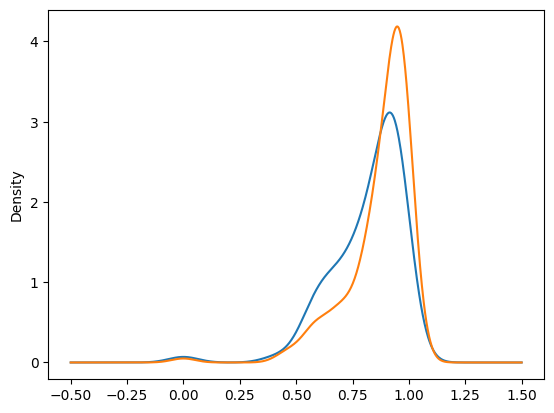

In [34]:
df[df.political_leaning_label.isin(['conservative','liberal'])].groupby(['political_leaning_label'])['ocrquality'].plot(kind='density')

# Exercise: price and OCR quality

If the OCR of the halfpenny press (½ d) worse than those papers that cost 1d

In [38]:
df.price_label.value_counts()

price_label
1d                 270
½ d<SEP>1d          48
½ d                 26
1d<SEP>2d           25
1 ½ d               15
4 ½ d               11
3 ½ d<SEP>4 ½ d     11
3d<SEP>4d            5
3 ½ d<SEP>1d         5
1d<SEP>1d            3
1 ½ d<SEP>2 ½ d      3
2d                   2
2 ½ d<SEP>3 ½ d      1
4d                   1
1id<SEP>1d           1
Name: count, dtype: int64

In [41]:
# enter your answer here, adapt the previous line of code df[df.political_leaning_label.


## Counting Words

## Regular Expressions

Regular expression for search multiple words

In abstract terms the regex looks like
`"\b(query_1|query_2|...|query_n)\b"`

- `\b` indicates a word break, can be a white space or interpunction symbol
- `|` indicates OR, i.e. we want to find any of the queried items
- `s?` ensures we include plural forms

In [ ]:
# define the regular expression
regex = r"\b(trains?|rails?)\b"
# compile the regex use an ignore case flag
# i.e. we will ignore uppercase
pattern = re.compile(regex, re.I)

In [ ]:
example_text = 'I took to trAin from Euston to Lancaster, but thetrain was delayed because there were leaves on the rails!'
pattern.findall(example_text)

['trAin', 'rails']

Instead of just one example, we can apply the regular expression to all items in the `text` column. For this we need to apply the `.apply` method (what's in name!) to the text column.

What does it return. For each row it will try to find matches for the query terms, and return an empty list (or `[]`) in case it does not find anything!

Applying to regex

In [ ]:
df['text'].apply(pattern.findall)

0      []
1      []
2      []
3      []
4      []
       ..
485    []
495    []
496    []
497    []
499    []
Name: text, Length: 427, dtype: object

Of course, we want to store the result of the `pattern.findall` operation, and add the query results as a new column to the dataframe. In pandas this is relatively straightforwards and resembels that variable assignment operation.

After saving the results as a new column, we can also keep track of the number of items we could match in the text. These results are stored in the `num_hits` column.

In [ ]:
df['hits'] = df['text'].apply(pattern.findall) # safe the query results in a new column
df['num_hits'] = df['hits'].apply(len) # count the number of items found

In [ ]:
df['num_hits'].value_counts() # get the distribution of hits

num_hits
0    399
1     20
2      3
8      2
5      1
3      1
6      1
Name: count, dtype: int64

<Axes: xlabel='num_hits'>

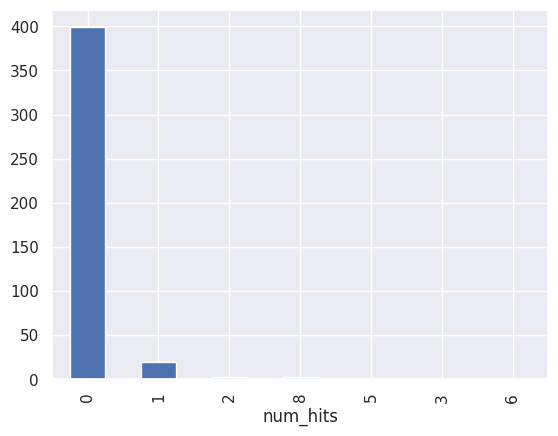

In [ ]:
df['num_hits'].value_counts().plot(kind='bar') # plot the distribution as a bar chart

We can inspect the result

In [ ]:
df_with_hits = df[df.num_hits > 0].reset_index()
df_with_hits[['hits','text']]

,hits,text
0,[trains],LEES. ACCIDENT TO A PIECED AT SPRINOREAD. An ...
1,[train],"""Well, I shall easily find her. I know you mus..."
2,[trains],"FROM WARRINGTON Acton Bridge-7 10, 7 40, 8 28..."
3,[Rail],"The HERALD, Saturday, Oct.. 9, 187.5. quotati..."
4,"[Rail, Rail]",STEAM TO A.USTRALIA UNDER. SIXTY DAYS PASSAOz...
5,[train],"OWNERS BET, and that very often the stake its..."
6,"[train, train, train, train, train]","A VOYAGE TO AM told US We ""silk tone, seeme..."
7,[train],WEYNOUTH. DiMAGES BY A RUN AWAY HORSE.—On Wed...
8,"[Train, train]","THOS. G. BRYER, AUCTIONEER AND APPRAISER, DO H..."
9,"[train, train, train, train, train, train, tra...",ALAMMILT' RAILWAY COLLISION. A collision of a...


In [ ]:
print(df_with_hits.iloc[4][['hits','text']].text)

STEAM TO A.USTRALIA UNDER. SIXTY DAYS  PASSAOz MONET, £l4 AND UPWARDS.  13 ACk BALL LINE of BRITISH and LAUSTRALIAN BX-ROYAL MAIL PACKETS, and EKOLE LINE of Packets, in conjunction with thesciebrated Auxitiary . . Screw Steam Clipper 'vREAT BRITAIN appointed to Sail punctually from Liverctusl on the sth and 13th ot each ntouth, te the consignmest of Bright, Brothers and Co., Melbourne.  The above Line' in addition to being the only r.ne with Steaoms out of Liverpool, is composed of the LAROEST, FINEST, AND FASTEST MERCHANT SHIPS IN THA WORLD.  Shin. Register. Burthen. Captain. Date. Great Britain 1763 500h.p, Gray July 16 Lightning 1769 6000 Clarke Aug. 5 Empress of theScal 757 5000 Bragg to follow Marco Polo 1625 4500 Johnston to follow To be succeeded by the following clippers and steamers— Great Britain Marco Polo Lightning Ocean Chief Champion of the Seas British Trident Donald he Kay Oipsey Bride Great Tasmania Morning Light Eagle Commodore Perry Saidantha Montmorency The above ce

## Exercise

Search the newspaper sample for two (or more!) words of choice.

## Easy version

Select to query terms and see how often these appear in the corpus

In [ ]:
query_1 = '' # add a query term between the quotation marks
query_2 = '' # add a query term between the quotation marks

regex = rf"\b({query_1}|{query_2})\b"
# compile the regex use an ignore case flag
# i.e. we will ignore uppercase
pattern = re.compile(regex, re.I) # compile
df['hits'] = df['text'].apply(pattern.findall) # safe the query results in a new column
df['num_hits'] = df['hits'].apply(len) # count the number of items found
df['num_hits'].value_counts()

num_hits
0    411
1     13
2      1
3      1
5      1
Name: count, dtype: int64

## Advanced version

- define a new regular expression that queries the corpus for at least 2 words
- Look at the previous examples and adapt the code to plot the distribution of the hits

In [ ]:
regex = ''
pattern = re.compile(regex, re.I) # compile
df['hits'] = df['text'].apply
= df['hits'].apply(len)
# plot the distribution of hits

SyntaxError: invalid syntax (<ipython-input-121-d3cb6ee489cc>, line 4)

# Timelines

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/kasparvonbeelen/lancaster-newspaper-workshop/wc/data/subsample500mixedocr-selected_mitch.csv")
df.dropna(inplace=True)

# define the regular expression
regex = r"\b(trains?|rails?)\b"
# compile the regex use an ignore case flag
# i.e. we will ignore uppercase
pattern = re.compile(regex, re.I)
df['hits'] = df['text'].apply(pattern.findall) # safe the query results in a new column
df['num_hits'] = df['hits'].apply(len) # count the number of items found


<Axes: xlabel='year'>

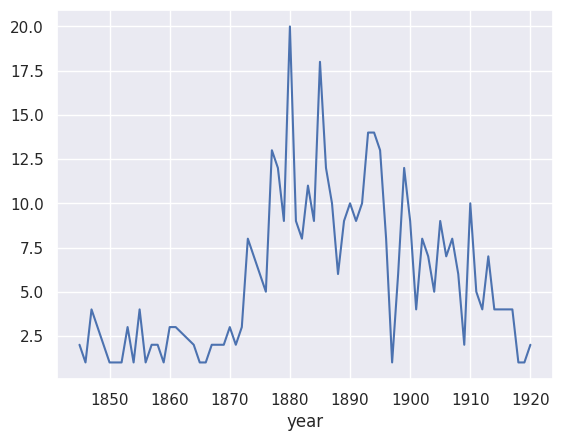

In [ ]:
df.groupby('year')['num_hits'].count().plot()

In [ ]:
an_example_text = "This sentence has 5 words."
words = an_example_text.split()
print(words)
num_words = len(words)
print(num_words)

['This', 'sentence', 'has', '5', 'words.']
5


In [ ]:
sentence = "This sentence has 5 words."
len(sentence.split())

5

<Axes: ylabel='Frequency'>

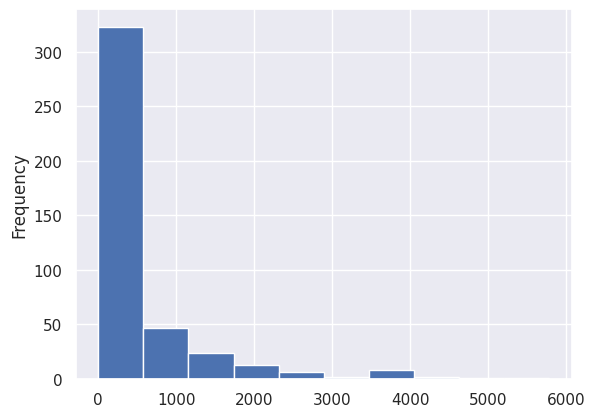

In [ ]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
df['num_words'].plot(kind='hist')

<Axes: xlabel='year'>

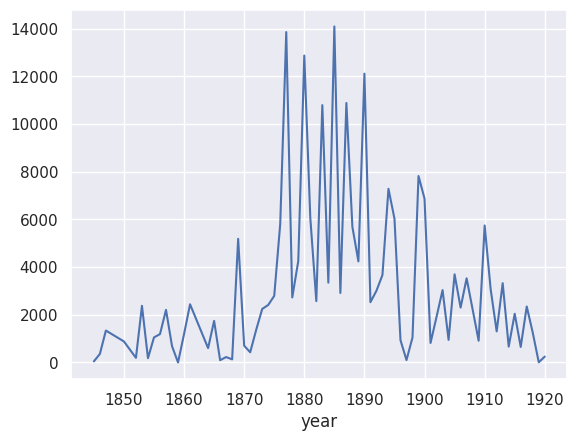

In [ ]:
df.groupby('year')['num_words'].sum().plot()

<Axes: xlabel='year'>

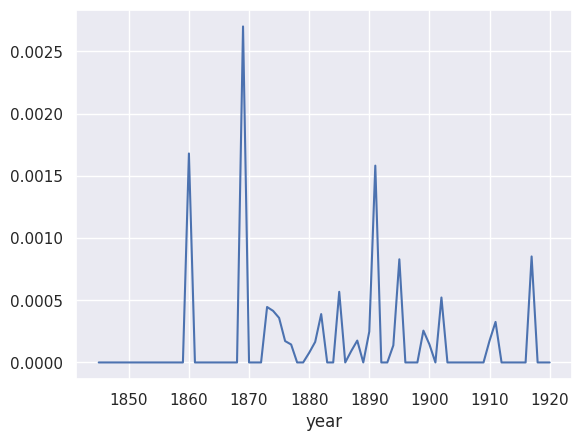

In [ ]:
df_grouped = df.groupby('year').apply(lambda x: x['num_hits'].sum() / x['num_words'].sum())
#df_grouped = df_grouped.rename('ratio')
df_grouped.plot()

In [ ]:
import seaborn as sns
sns.set()

<Axes: xlabel='year', ylabel='ratio'>

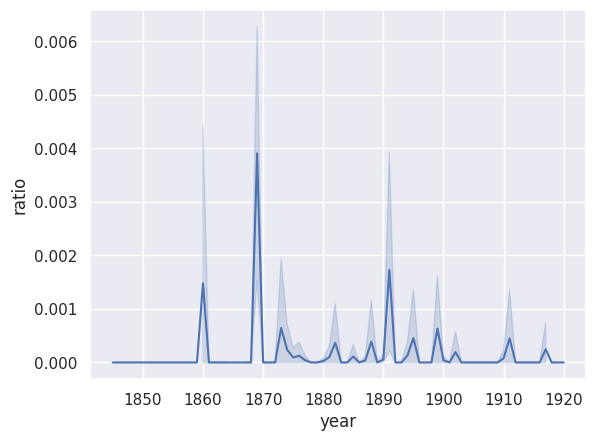

In [ ]:
df['ratio'] = df['num_hits'] /  df['num_words']
sns.lineplot(x='year',y='ratio', data=df)

In [ ]:
from random import shuffle, random
scores = [random() for _ in range(100)]
scores[:10]

[0.4113766808864,
 0.3835951845181812,
 0.6870594319947726,
 0.6164726439551994,
 0.3645820263145316,
 0.8386758257043299,
 0.09914530384532516,
 0.05050088285157328,
 0.7861183333982567,
 0.6279227350179232]

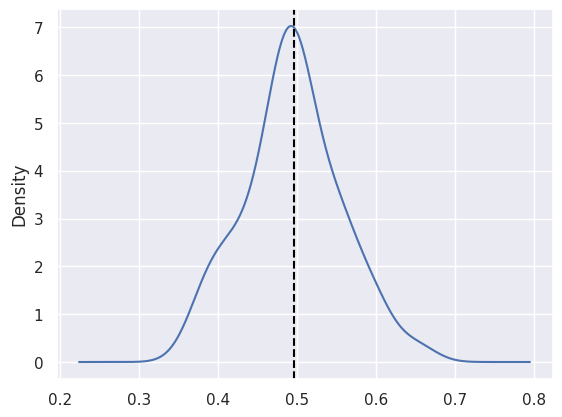

In [ ]:
size = 20
n_trials = 100
means = []
for _ in range(n_trials):
  shuffle(scores)
  means.append(sum(scores[:size]) / size)
ax = pd.Series(means).plot(kind='density')
ax.axvline(sum(scores)/len(scores), color="black", linestyle="dashed")

[0.3857257  0.59932831]


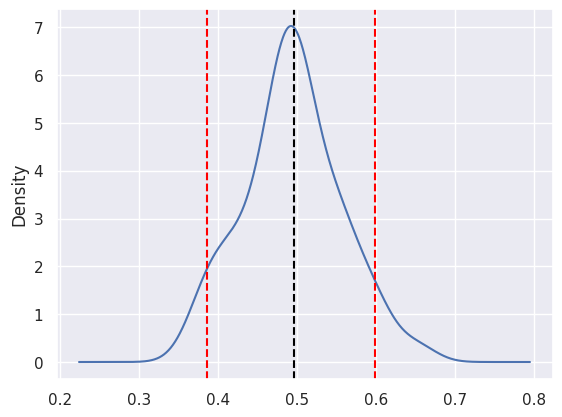

In [ ]:
import numpy as np
percentiles = np.percentile(means,q=[5.,95.])
print(percentiles)
ax = pd.Series(means).plot(kind='density')
ax.axvline(sum(scores)/len(scores), color="black", linestyle="dashed")
ax.axvline(percentiles[0], color="red", linestyle="dashed")
ax.axvline(percentiles[1], color="red", linestyle="dashed")

## Politics

In [ ]:
df.political_leaning_label.unique()

array(['liberal', 'independent', 'neutral', 'constitutional',
       'liberal; conservative', 'unionist', 'independent; conservative',
       'conservative'], dtype=object)

## Exercise

Create a simplified schema of these political labels, map the labels to this simplified schema, in a new column `political_labels_simplified`.

In [ ]:
mapping = {'liberal': 'left',
           'independent': 'non-aligned',
           'neutral': 'non-aligned',
           'constitutional': 'right',
            'liberal; conservative': 'non-aligned',
            'unionist':'right',
            'independent; conservative': 'right',
            'conservative':'right'}

In [ ]:
df['political_labels_simplified'] = df['political_leaning_label'].replace( mapping)

In [ ]:
df['political_labels_simplified'].value_counts()

political_labels_simplified
non-aligned    163
left           151
right          113
Name: count, dtype: int64

([0, 1, 2],
 [Text(0, 0, 'left'), Text(1, 0, 'non-aligned'), Text(2, 0, 'right')])

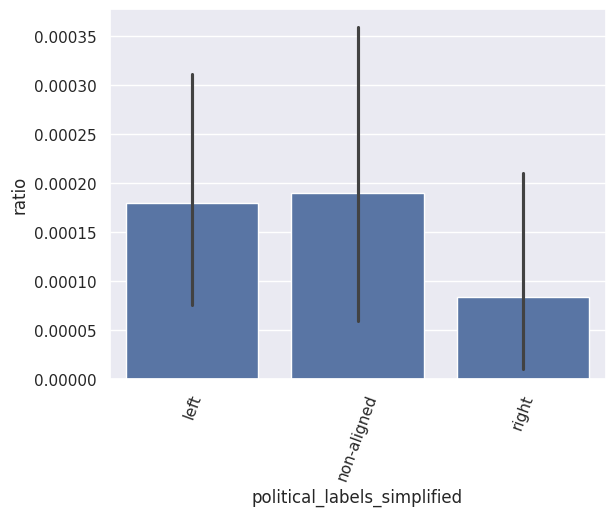

In [ ]:
import matplotlib.pyplot as plt
sns.barplot(x='political_labels_simplified',y='ratio', data=df)
plt.xticks(rotation=70)

## Exercise

Let's now play with a bit larger dataset.